In [1]:
from collections import Counter
from itertools import product
import os
from pathlib import Path
import sys

from Bio.Align import AlignInfo, MultipleSeqAlignment
import Bio.motifs as motifs
from Bio.SeqFeature import FeatureLocation
from Bio.SeqRecord import SeqRecord
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from math import log,exp,inf
sys.path.append('../bitome-kb')
from bitome.core import Bitome

In [2]:
import ast
im_info = pd.read_csv('data/precise2_im_info_new.csv')
IM_genes = {}
for i in range(len(im_info['im_name'])):
    IM_genes[im_info['im_name'][i]] = ast.literal_eval( im_info['genes'][i] )
IM_genes.keys()

dict_keys(['CysB-1', 'HprR+CusR', 'PhoB-1', 'Fnr-1', 'TdcAR', 'Fimbriae', 'PurR-2', 'Fnr+NarL', 'GalRS', 'BtsR', 'PyrR', 'PlaR', 'RpoN+FhlA', 'RhaS', 'NanR', 'FadR', 'NrdR', 'GlcC', 'BaeR+CpxR', 'NikR', 'Isoleucine', 'RpoN+PspF', 'OxyR', 'TrpR', 'CsqR', 'LldR', 'Thiamine-1', 'PuuR', 'YcjW', 'PdhR+OmpR', 'NsrR', 'GntR', 'Fnr+NarLP', 'RcsAB', 'MalT', 'TyrR', 'Molybdopterin', 'Fnr-2', 'AtoC', 'Leucine', 'SoxS', 'Translation', 'RcnR', 'Lrp', 'Nac', 'KdpE', 'PhoB-2', 'RbsR', 'CysB-2', 'FlhDC-1', 'GatR', 'ArgR', 'GadX', 'RpoN+NtrC-1', 'XylR', 'ArcA', 'BirA', 'EvgA', 'BluR', 'LsrR', 'Zur', 'RpoE', 'Fur-1', 'PurR-1', 'ArgP', 'AllR', 'FucR', 'Fur-2', 'Mlc', 'CecR', 'Fnr+IHF+gcvB', 'YgbI', 'LexA', 'Cra', 'GlpR', 'RpoN+NtrC-2', 'PaaX', 'Oligopeptide', 'CdaR', 'RpoN+PrpR+Cra', 'FliA', 'CpxR', 'Histidine', 'RpoH', 'GadE+FliZ', 'GcvA', 'YdeO+H-NS', 'NagC', 'GutM+SrlR', 'MetJ', 'RpoS', 'CysB-3', 'FlhDC-2', 'RutR', 'PhoP', 'RyhB', 'BasR', 'NarL', 'RpoS+ArgR+RpoN', 'Crp-related-2'])

In [3]:
bitome = Bitome.init_from_file('../bitome-kb/bitome.pkl')

In [4]:
tf_list =['AraC', 'ArcA', 'ArgP', 'ArgR', 'BaeR', 'BasR', 'CysB', 'CpxR', 
          'Cra', 'CRP', 'Mlc', 'MqsA', 'EvgA', 'ExuR', 'FadR', 'IclR', 'IscR', 
          'IHF', 'FhlA', 'FlhDC', 'FNR', 'Fur', 'GadE', 'GadW', 'GadX', 'GalR', 'GalS', 
          'GcvA', 'GlpR', 'GlrR', 'GntR', 'TyrR', 'LexA', 'LeuO', 'Lrp', 'MalT', 'MetJ', 'Nac', 
          'NagC', 'NanR', 'NarL', 'NarP', 'NrdR', 'NsrR', 'NtrC', 'OmpR', 'OxyR', 'PdhR', 'PhoB', 'PhoP',
          'PurR', 'PuuR', 'RcsAB', 'RhaS', 'RutR', 'SoxS', 'TrpR', 'XylR', 'YdeO']

regulon_genes={}
for TF in bitome.transcription_factors:
    if TF.name in tf_list:
        regulon_genes[TF.name] = []   
        for r in TF.regulons:
                for p in list(r.regulated_promoters.values())[0]:
                    if p.transcription_unit != None and len(p.transcription_unit.genes)>0:
                        for g in p.transcription_unit.genes:
                            regulon_genes[TF.name].append( g.locus_tag)

In [5]:
TF_SN = pd.read_csv('data/all_tf_data.csv')
TF_SN = TF_SN[['TF','SN_ratio','TU','start','stop','log_SN']]
TF_SN = TF_SN.dropna()
fur_SN = TF_SN.iloc[0:143]
soxS_SN = TF_SN.iloc[153:179]
oxyR_SN = TF_SN.iloc[179:211]

In [6]:
keep_ind = []
for i in range( len(fur_SN['TU']) ):
    if list( fur_SN['TU'] ).count( fur_SN['TU'][i] ) == 1:
        keep_ind.append( i )
fur_SN = fur_SN.iloc[keep_ind,:]
fur_SN = fur_SN.reset_index()
fur_SN= fur_SN.drop(columns=['index'])

In [7]:
rawdata = pd.read_csv('data.csv')

In [8]:
fur_SN_index = []
for i in range(len(rawdata['TU'])):
    if list( rawdata['TU'])[i] in list(fur_SN['TU']):
        fur_SN_index.append(i)
fur_SN_feature = rawdata.iloc[ fur_SN_index ]
fur_SN_feature = fur_SN_feature.reset_index()
fur_SN_feature = fur_SN_feature.drop(columns=['index'])
fur_SN_feature.head()

,ID,gene,TU,strand,TU_length,leading,lagging,terminus,Sigma70_Prib_Start,Sigma70_Prib_score,...,EP_TSS_1,EP_TSS_2,EP_TSS_3,EP_TSS_4,EP_TSS_5,EP_TSS_6,EP_TSS_7,EP_TSS_8,EP_TSS_9,EP_TSS_10
0,b0064,araC,araC,1,1025,1,0,0,-12,-9.343095,...,-7.46,-7.49,-5.65,-5.00,-5.14,-5.31,-5.66,-6.00,-7.76,-7.05
1,b0131,panD,panD,-1,432,0,1,0,-11,-6.320705,...,-6.94,-5.52,-5.71,-5.50,-7.09,-6.72,-5.52,-8.05,-8.88,-8.81
2,b0131,panD,panD,-1,441,0,1,0,-12,-6.479392,...,-5.64,-7.51,-7.16,-7.16,-7.51,-5.64,-5.43,-7.15,-5.58,-6.94
3,b0237,pepD,pepD,-1,1518,0,1,0,-6,-7.049679,...,-8.97,-8.76,-7.80,-5.20,-4.82,-5.14,-5.59,-5.32,-6.98,-5.68
4,b0237,pepD,pepD,-1,1551,0,1,0,-11,-4.003152,...,-8.64,-9.42,-10.80,-9.65,-8.05,-5.96,-6.55,-5.70,-5.25,-6.93


In [9]:
rm_list = []
for i in range(len(fur_SN['TU'])):
    if fur_SN['TU'][i] not in list(fur_SN_feature['TU']):
        rm_list.append(i)
fur_SN = fur_SN.drop(rm_list)
fur_SN = fur_SN.reset_index()
fur_SN= fur_SN.drop(columns=['index'])

In [10]:
fur_SN_feature = fur_SN_feature.merge(fur_SN, on='TU')
fur_SN_feature = fur_SN_feature.dropna()
fur_SN_feature.head()

,ID,gene,TU,strand,TU_length,leading,lagging,terminus,Sigma70_Prib_Start,Sigma70_Prib_score,...,EP_TSS_6,EP_TSS_7,EP_TSS_8,EP_TSS_9,EP_TSS_10,TF,SN_ratio,start,stop,log_SN
0,b0064,araC,araC,1,1025,1,0,0,-12,-9.343095,...,-5.31,-5.66,-6.00,-7.76,-7.05,fur,1.67,70524.0,70536.0,0.512824
1,b0131,panD,panD,-1,432,0,1,0,-11,-6.320705,...,-6.72,-5.52,-8.05,-8.88,-8.81,fur,2.93,146494.0,146507.0,1.075002
2,b0131,panD,panD,-1,441,0,1,0,-12,-6.479392,...,-5.64,-5.43,-7.15,-5.58,-6.94,fur,2.93,146494.0,146507.0,1.075002
3,b0237,pepD,pepD,-1,1518,0,1,0,-6,-7.049679,...,-5.14,-5.59,-5.32,-6.98,-5.68,fur,5.83,255803.0,255815.0,1.763017
4,b0237,pepD,pepD,-1,1551,0,1,0,-11,-4.003152,...,-5.96,-6.55,-5.70,-5.25,-6.93,fur,5.83,255803.0,255815.0,1.763017


In [11]:
fur_SN_feature

,ID,gene,TU,strand,TU_length,leading,lagging,terminus,Sigma70_Prib_Start,Sigma70_Prib_score,...,EP_TSS_6,EP_TSS_7,EP_TSS_8,EP_TSS_9,EP_TSS_10,TF,SN_ratio,start,stop,log_SN
0,b0064,araC,araC,1,1025,1,0,0,-12,-9.343095,...,-5.31,-5.66,-6.00,-7.76,-7.05,fur,1.67,70524.0,70536.0,0.512824
1,b0131,panD,panD,-1,432,0,1,0,-11,-6.320705,...,-6.72,-5.52,-8.05,-8.88,-8.81,fur,2.93,146494.0,146507.0,1.075002
2,b0131,panD,panD,-1,441,0,1,0,-12,-6.479392,...,-5.64,-5.43,-7.15,-5.58,-6.94,fur,2.93,146494.0,146507.0,1.075002
3,b0237,pepD,pepD,-1,1518,0,1,0,-6,-7.049679,...,-5.14,-5.59,-5.32,-6.98,-5.68,fur,5.83,255803.0,255815.0,1.763017
4,b0237,pepD,pepD,-1,1551,0,1,0,-11,-4.003152,...,-5.96,-6.55,-5.70,-5.25,-6.93,fur,5.83,255803.0,255815.0,1.763017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,b4289,fecC,fecABCDE,-1,6038,0,1,0,-17,-6.641246,...,-7.34,-7.57,-6.07,-7.34,-6.99,fur,8.20,4514757.0,4514768.0,2.104134
98,b4290,fecB,fecABCDE,-1,6038,0,1,0,-17,-6.641246,...,-7.34,-7.57,-6.07,-7.34,-6.99,fur,8.20,4514757.0,4514768.0,2.104134
99,b4291,fecA,fecABCDE,-1,6038,0,1,0,-17,-6.641246,...,-7.34,-7.57,-6.07,-7.34,-6.99,fur,8.20,4514757.0,4514768.0,2.104134
100,b4322,uxuA,uxuAB,1,2844,1,0,0,-6,-7.237035,...,-5.30,-6.24,-7.82,-6.99,-6.22,fur,1.53,4549516.0,4549528.0,0.425268


Text(0.5, 0, 'log(SN):Fur')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


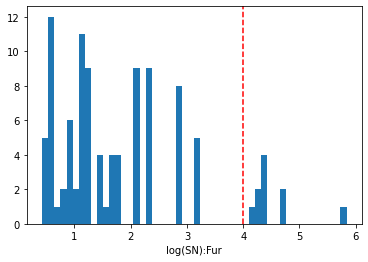

In [14]:
plt.hist( fur_SN_feature['log_SN'], bins = 50 );
plt.axvline(x=4,linestyle='--',c='r')
plt.xlabel('log(SN):Fur')

Text(0.5, 0, 'SN:Fur')

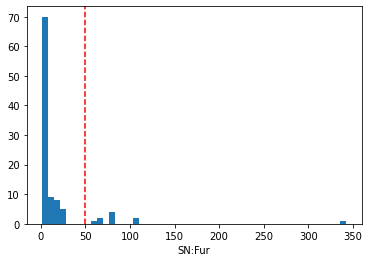

In [15]:
plt.hist( fur_SN_feature['SN_ratio'], bins = 50 );
plt.axvline(x=50,linestyle='--',c='r')
plt.xlabel('SN:Fur')

Text(0.5, 0, 'Fur-2 IM PWM')

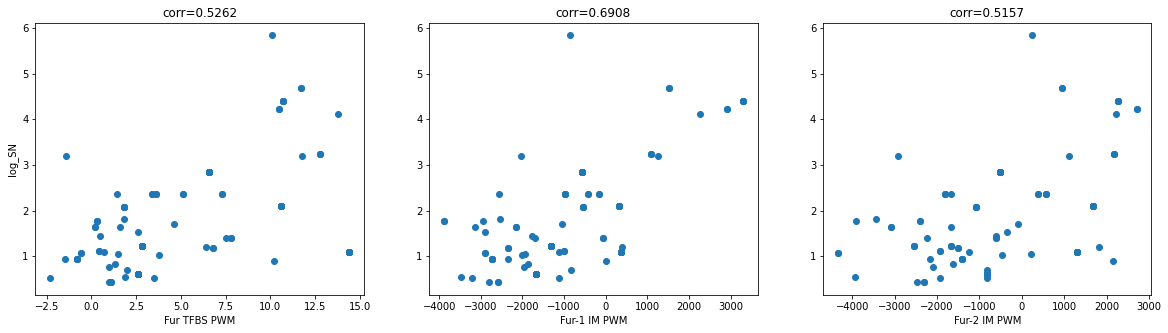

In [23]:
fig,axs = plt.subplots(1,3, figsize = ( 20,5))
axs[0].scatter( fur_SN_feature['Fur score'],  fur_SN_feature['log_SN'])
axs[0].set_title( 'corr='+str( np.corrcoef( fur_SN_feature['Fur score'] , fur_SN_feature['log_SN'] )[0,1])[0:6] )
axs[0].set_ylabel('log_SN')
axs[0].set_xlabel('Fur TFBS PWM')
axs[1].scatter( fur_SN_feature['Fur-1 im score'],  fur_SN_feature['log_SN'])
axs[1].set_title(  'corr='+str( np.corrcoef( fur_SN_feature['Fur-1 im score'] , fur_SN_feature['log_SN'] )[0,1])[0:6] )
axs[1].set_xlabel('Fur-1 IM PWM')
axs[2].scatter( fur_SN_feature['Fur-2 im score'],  fur_SN_feature['log_SN'])
axs[2].set_title(  'corr='+str( np.corrcoef( fur_SN_feature['Fur-2 im score'] , fur_SN_feature['log_SN'] )[0,1])[0:6] )
axs[2].set_xlabel('Fur-2 IM PWM')

## Fur and logSN

In [13]:
fur_feature_range = [3,4,5,6,7]+list(range(469,488)) + list(range(1191,1210)) + list(range(1476,1495))
fur_features = list(fur_SN_feature.columns[3:8]) + list(fur_SN_feature.columns[469:488]) \
                    + list(fur_SN_feature.columns[1191:1210]) + list(fur_SN_feature.columns[1476:1495]) 

X_fur = fur_SN_feature.iloc[:,fur_feature_range ].values
X_fur = StandardScaler().fit_transform(X_fur)
featureList = list(fur_SN_feature.columns[3:2194])
log_SN_fur = list(fur_SN_feature['log_SN'])
SN_fur = list(fur_SN_feature['SN_ratio'])
high_genes = []
low_genes = []
log_highlow = []
highlow = []
for i in range( len(fur_SN_feature['log_SN']) ):
    if log_SN_fur[i] < 4:
        log_highlow.append(0)
        low_genes.append( fur_SN_feature['ID'][i]  )
    else:
        log_highlow.append(1)
        high_genes.append( fur_SN_feature['ID'][i] )
    
    if SN_fur[i] < 50:
        highlow.append(0)
    else:
        highlow.append(1)    

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


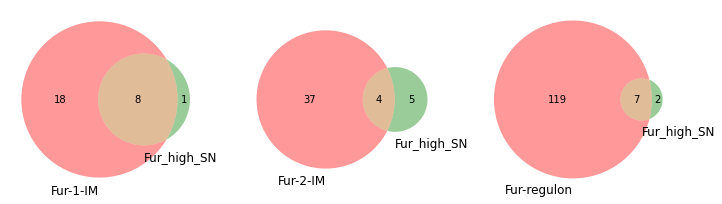

In [14]:
from matplotlib_venn import venn2
fig,axs = plt.subplots(1,3,figsize=(12,5))
venn2([set(IM_genes['Fur-1']),set(high_genes)],set_labels = ('Fur-1-IM','Fur_high_SN'),ax =axs[0])
venn2([set(IM_genes['Fur-2']),set(high_genes)],set_labels = ('Fur-2-IM','Fur_high_SN'),ax =axs[1])
venn2([set(regulon_genes['Fur']),set(high_genes)],set_labels = ('Fur-regulon','Fur_high_SN'),ax =axs[2])

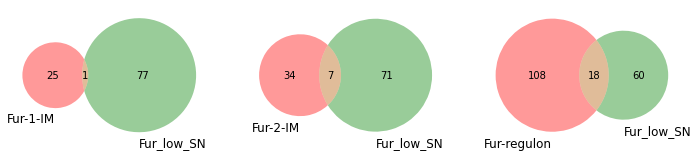

In [15]:
from matplotlib_venn import venn2
fig,axs = plt.subplots(1,3,figsize=(12,5))
venn2([set(IM_genes['Fur-1']),set(low_genes)],set_labels = ('Fur-1-IM','Fur_low_SN'),ax =axs[0])
venn2([set(IM_genes['Fur-2']),set(low_genes)],set_labels = ('Fur-2-IM','Fur_low_SN'),ax =axs[1])
venn2([set(regulon_genes['Fur']),set(low_genes)],set_labels = ('Fur-regulon','Fur_low_SN'),ax =axs[2])

## classification on high/low attempt

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight

In [17]:
y_to_try = {
    'SN_high/low':highlow,
    'log(SN)_high/low':log_highlow,
}

models_to_try = {
    'LR': LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        random_state=42
    ),
    'SVM': LinearSVC(
        penalty='l1',
        class_weight='balanced',
        dual=False,
        random_state=42,
        verbose=1
    ),
    'RF': RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        verbose=1
    )
}

In [18]:
result_df = pd.DataFrame(
    columns=['model', 'chip_peak', 'train_auc', 'test_auc']
)

N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for y_name, y_labels in y_to_try.items():
        print(f'{model_name}: {y_name}')
        
        cv_result = cross_validate(
            model,
            X_fur,
            y= y_labels,
            cv=N_CV,
            scoring='roc_auc',
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'chip_peak': [y_name] * N_CV,
                'train_auc': cv_result['train_score'],
                'test_auc': cv_result['test_score']
            }
        )

        result_df = result_df.append(sub_result_df)

LR
LR: SN_high/low


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


LR: log(SN)_high/low
SVM
SVM: SN_high/low
SVM: log(SN)_high/low


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF
RF: SN_high/low


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: log(SN)_high/low


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.5s finished


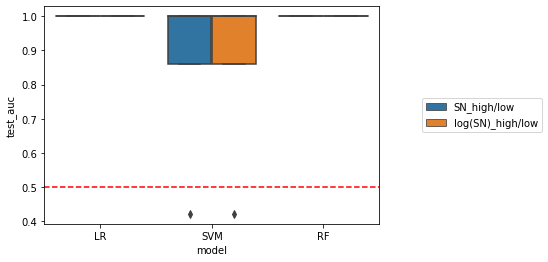

In [19]:
_, ax = plt.subplots()
sns.boxplot(x='model', y='test_auc', data=result_df, hue='chip_peak', dodge=True, ax=ax)
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5))
plt.axhline(y= 0.5, color = 'r', ls = '--')

In [20]:
hyperopt_models = {
    'LR': {
        'model': LogisticRegression(
            solver='saga',
            class_weight='balanced',
            verbose=1
        ),
        'param_dists': {
            'penalty': ['l1', 'l2'],
            'C': np.arange(0.01, 5, 0.05),
            'max_iter':np.array([100,200,500,1000,1500,2000])
        }
    },
    'SVM': {
        'model': LinearSVC(
            class_weight='balanced',
            dual=False,
            verbose=1
        ),
        'param_dists': {
            'penalty': ['l1', 'l2'],
            'loss': ['hinge', 'squared_hinge'],
            'C': np.arange(0.01, 5, 0.05)
        }
    },
    'RF': {
        'model': RandomForestClassifier(
            class_weight='balanced',
            verbose=1
        ),
        'param_dists': {
            'n_estimators': np.arange(10, 100, 5), # use smaller number of trees to reduce overfit
            'max_depth': np.arange(3, 15),
            'min_samples_split': np.arange(0.001, 0.02, 0.001),
            'min_samples_leaf': np.arange(5, 15)
        }
    }
}

In [21]:
hyperopt_m = {}

for model_name  in hyperopt_models.keys():
    print(model_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models[model_name]['model'],
        hyperopt_models[model_name]['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(X_fur, highlow)
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_m[model_name] = hyperopt_results_df

LR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  50 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    8.0s remaining:    0.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


convergence after 544 epochs took 0 seconds
SVM
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    1.0s finished
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[LibLinear]RF
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 118 out of 125 | elapsed:    6.5s remaining:    0.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    0.1s finished


Text(0, 0.5, 'ROC_auc')

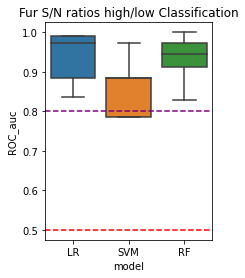

In [23]:
dfs_with_ims = []
for model_name, hyperopt_df in hyperopt_m.items():
    hyperopt_df['model'] = [model_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)   
hyperopt_models_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)


fig = plt.figure(figsize = (3,4))
#sns.swarmplot(x='model', y='mean_train_score', data=hyperopt_models_df)
sns.boxplot(x='model', y='mean_test_score', data=hyperopt_models_df)
plt.axhline(y= 0.8, color = 'purple', ls = '--')
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.title('Fur S/N ratios high/low Classification')
plt.ylabel('ROC_auc')

In [50]:
hyperopt_models_df[hyperopt_models_df['model']=='LR']['params'][0]

{'penalty': 'l1', 'max_iter': 200, 'C': 1.9100000000000001}

In [24]:
import shap
from sklearn.model_selection import train_test_split

X_fi = pd.DataFrame( X_fur, columns= fur_features , index=fur_SN_feature.index )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.1s finished


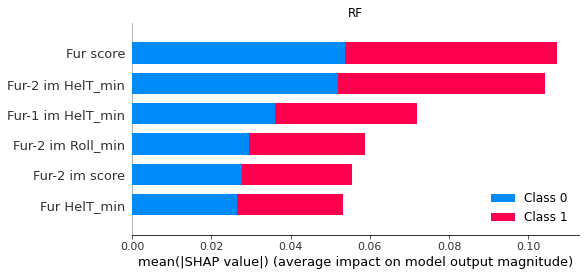

In [39]:
X_train, X_test, y_train, y_test = train_test_split( X_fi, highlow, test_size=0.3, random_state=7)

clf = RandomForestClassifier(class_weight='balanced',n_estimators = 65,min_samples_split= 0.005,min_samples_leaf=9,
                max_depth=3, verbose=1)

clf.fit(X_train, y_train)
explainer = shap.TreeExplainer( clf )
plt.title('RF')
shap_values = explainer.shap_values( X_test )
shap.summary_plot(shap_values, X_test, max_display=6)

In [43]:
temp_list = [('Fur-2 im score', 0.1026778479800882), ('Fur score', 0.09636914798518491), ('Fur-1 im score', 0.09447934659046342), ('Fur-1 im MGW_max', 0.07284675678287675), ('Fur-1 im HelT_min', 0.0705513083558426), ('Fur-1 im HelT_range', 0.06434636927352344), ('Fur-2 im ProT_range', 0.05841141134775561), ('Fur-1 im Roll_min', 0.052662367255526844), ('Fur-2 im Roll_min', 0.04080444928182345), ('Fur-2 im MGW_max', 0.03958838996902603)]
table_list = []
for f,v in temp_list:
    table_list.append( (f, round(v,4) ))

pd.DataFrame(table_list,columns = ['RF_feature','importance'])

,RF_feature,importance
0,Fur-2 im score,0.1027
1,Fur score,0.0964
2,Fur-1 im score,0.0945
3,Fur-1 im MGW_max,0.0728
4,Fur-1 im HelT_min,0.0706
5,Fur-1 im HelT_range,0.0643
6,Fur-2 im ProT_range,0.0584
7,Fur-1 im Roll_min,0.0527
8,Fur-2 im Roll_min,0.0408
9,Fur-2 im MGW_max,0.0396


Liblinear failed to converge, increase the number of iterations.


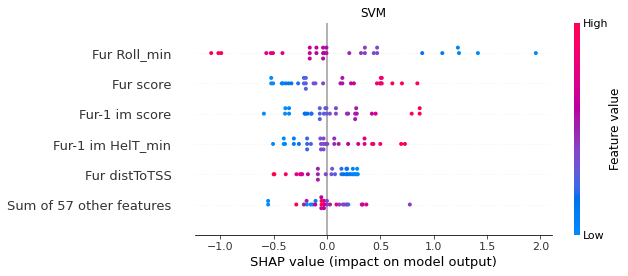

In [32]:
X_train, X_test, y_train, y_test = train_test_split( X_fi, highlow, test_size=0.3, random_state=7)
clf = LinearSVC(penalty = 'l1',dual=False, loss='squared_hinge',C= 2.11)

clf.fit(X_train, y_train)
explainer = shap.Explainer(clf, X_train )
shapval = explainer(X_test)
plt.title('SVM')
shap.plots.beeswarm(  shapval,max_display=6 )

The max_iter was reached which means the coef_ did not converge


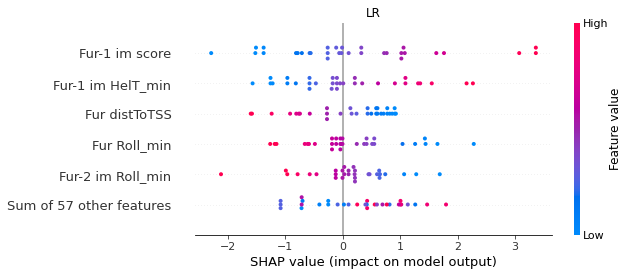

In [34]:
X_train, X_test, y_train, y_test = train_test_split( X_fi, highlow, test_size=0.3, random_state=7)
clf = LogisticRegression(solver='saga',penalty = 'l1',C= 1.91, max_iter =200 )
clf.fit(X_train, y_train)
explainer = shap.Explainer(clf, X_train )
shapval = explainer(X_test)
plt.title('LR')
shap.plots.beeswarm(  shapval,max_display=6 )

## Regression

In [26]:
models_to_try = {
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RF': RandomForestRegressor(
        random_state=42,
        n_jobs=4
    )
}

y_to_try = {
    'log_SN_fur ':log_SN_fur,
    'SN_fur':SN_fur,
}

In [28]:
result_df = pd.DataFrame(
    columns=['model', 'SN', 'train_r2', 'test_r2']
)

N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for y_name, y_values in y_to_try.items():
        print(f'{model_name}: {y_name}')  
        
        cv_result = cross_validate(
            model,
            X_fur,
            y= y_values,
            cv=N_CV,
            scoring='r2',
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'SN': [y_name] * N_CV,
                'train_r2': cv_result['train_score'],
                'test_r2': cv_result['test_score']
            }
        )

        result_df = result_df.append(sub_result_df)

ElasticNet
ElasticNet: log_SN_fur 


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ElasticNet: SN_fur


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVR
SVR: log_SN_fur 


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVR: SN_fur


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF
RF: log_SN_fur 


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: SN_fur


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.0s finished


(-1.0, 1.0)

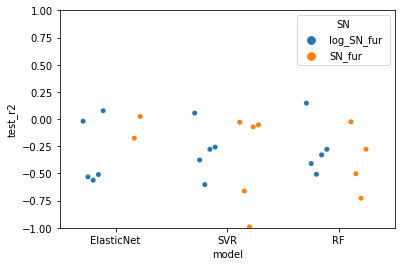

In [31]:
_, ax = plt.subplots()
sns.swarmplot(x='model', y='test_r2', data=result_df, hue='SN', dodge=True, ax=ax)
ax.set_ylim(-1,1)

# hyptuning on logSN

In [38]:
hyperopt_models = {
    'ElasticNet': {
        'model':ElasticNet(random_state=42),
        'param_dists': {
            'l1_ratio': np.arange(0.0, 1, 20),
             'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
             'selection':['cyclic', 'random']         
        }
    },
    'SVR': {
        'model': SVR(kernel='rbf',degree=3,epsilon=0.1),
        'param_dists': {
            'degree': [3,4,5,6,7,8,9,10],
            'gamma': ['scale', 'auto'],
            'C': np.arange(0.01, 10, 0.05),
        }
    },
    'RFR': {
        'model': RandomForestRegressor( verbose=1,random_state=42),
        'param_dists': {
            'n_estimators': np.arange(50, 250, 10),
            'max_depth': np.arange(3, 15),
            'min_samples_split': np.arange(0.001, 0.02, 0.001),
            'min_samples_leaf': np.arange(5, 15)
        }
    }
}

In [41]:
hyperopt_RFR = {}

for y_name, y_values in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['RFR']['model'],
        hyperopt_models['RFR']['param_dists'],
        n_iter=25,
        scoring='r2',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(X_fur,y_values )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_RFR[y_name] = hyperopt_results_df
    
dfs_with_SN = []
for y_name, hyperopt_df in hyperopt_RFR.items():
    hyperopt_df['SN'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_SN.append(hyperopt_df)
    
hyperopt_RFR_df = pd.concat(dfs_with_SN, axis=0, ignore_index=True)

log_SN_fur 
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   12.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SN_fur
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   13.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


Text(0, 0.5, 'r2')

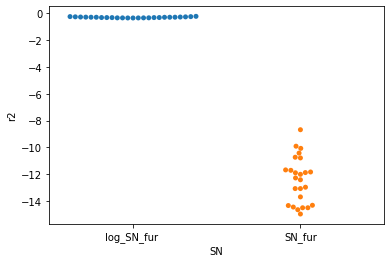

In [43]:
_, ax = plt.subplots()
sns.swarmplot(x='SN', y='mean_test_score', data= hyperopt_RFR_df,ax = ax )
ax.set_ylabel('r2')

# Multi strain work for Fur

In [31]:
strains = ['042','BL21','CFT073','Crooks','KO11FL','Sakai','W','W3110'];
Fur_multi_table = {}
for strain in strains:
    Fur_multi_table[strain] = pd.read_csv('data/Fur_multistrain_SN/ecoli_'+strain+'_SN.csv')

In [32]:
Fur_multi_table['Crooks'].head()

,Reference genome,ChIP-exo Start,ChIP-exo End,S/N ratio
0,NC_010468.1,23793,23805,6.173784
1,NC_010468.1,27526,27538,4.846829
2,NC_010468.1,80827,80839,2.899666
3,NC_010468.1,86534,86546,2.238391
4,NC_010468.1,132643,132655,1.825058


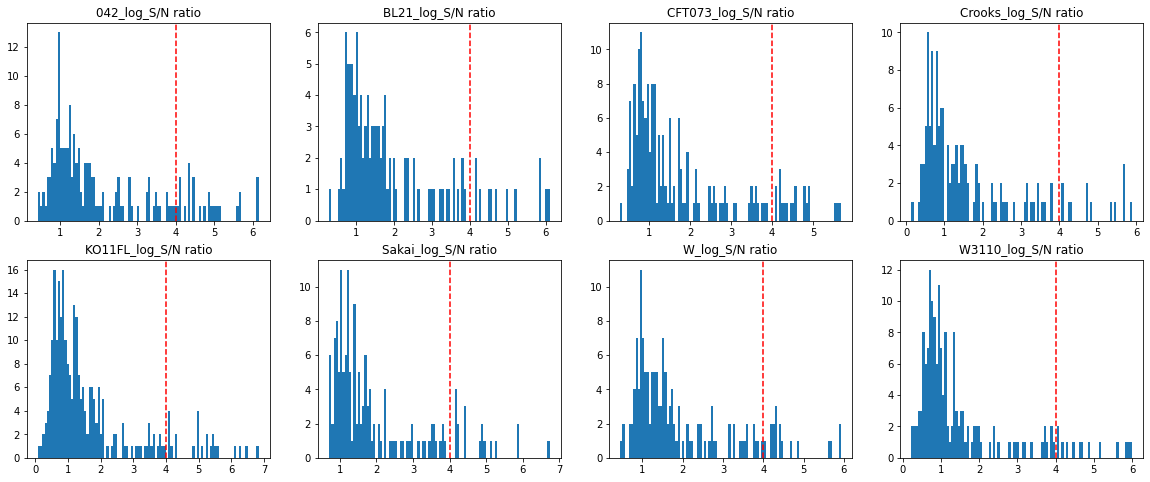

In [33]:
fig,axs = plt.subplots(2,4,figsize= (20,8))
for i in range(len(strains)):
    x = int(i/4)
    y = int(i%4)
    log_sn = [ log(x) for x in list(Fur_multi_table[strains[i]]['S/N ratio']) ]
    axs[x][y].hist( log_sn ,bins = 100 )
    axs[x][y].set_title(strains[i]+'_log_S/N ratio')
    axs[x][y].axvline(x=4,linestyle='--',c='r')

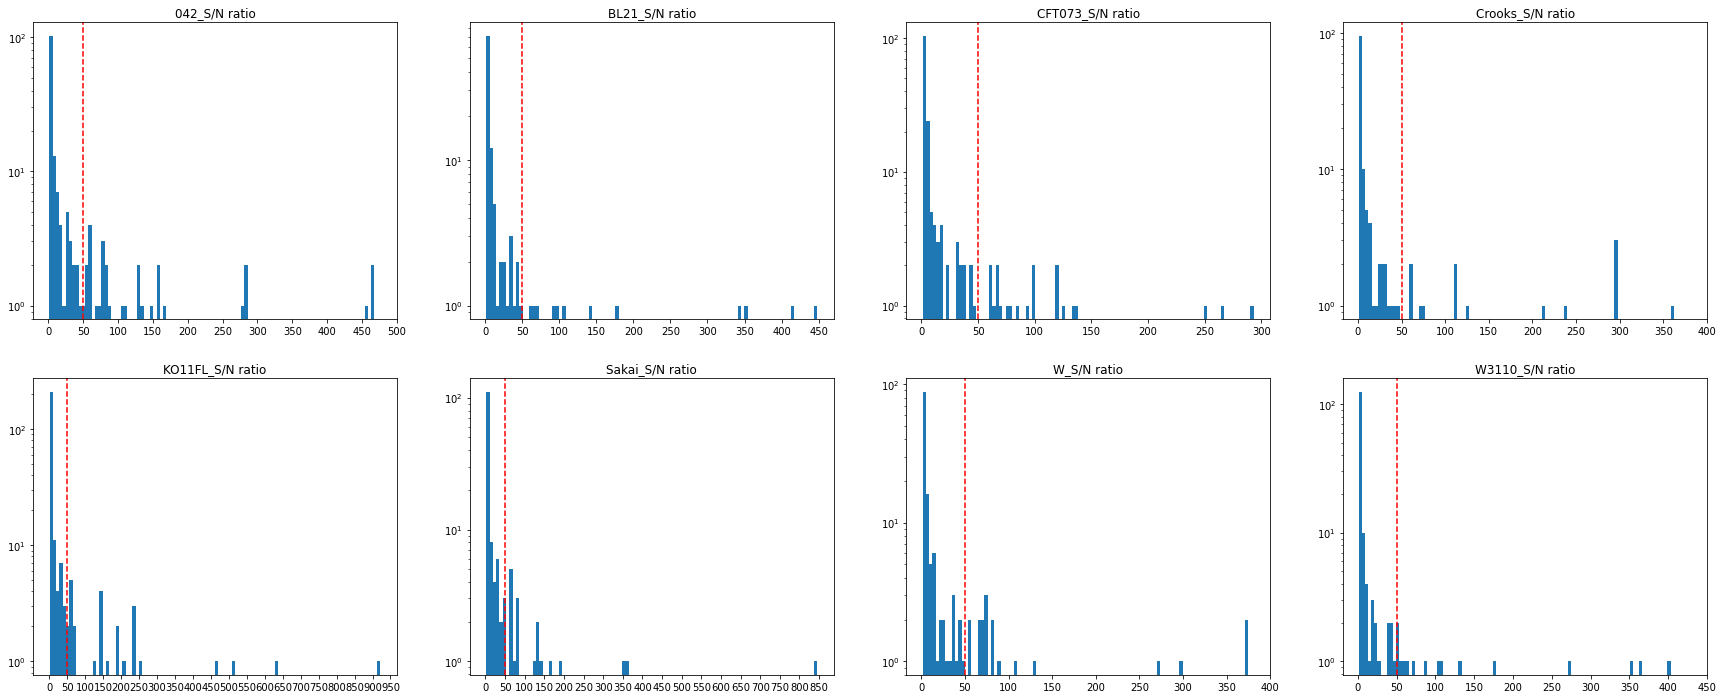

In [36]:
fig,axs = plt.subplots(2,4,figsize= (30,12))
for i in range(len(strains)):
    x = int(i/4)
    y = int(i%4)
    sn =  list(Fur_multi_table[strains[i]]['S/N ratio'])
    axs[x][y].hist( sn ,bins = 100 )
    axs[x][y].set_title(strains[i]+'_S/N ratio')
    axs[x][y].axvline(x=50,linestyle='--',c='r')
    axs[x][y].set_xticks(np.arange(0,max(sn)+50,50))
    axs[x][y].set_yscale('log')